Student Performance Prediction - predicting student's final grades based on their attendance , past scores, and possibly ohter factors like study time or parental education.

Project Goal: To Predict a student's final exam score (regression problem)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [31]:
df = pd.read_csv('student-mat.csv', sep=';')

In [32]:
features = [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
    'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
    'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup',
    'paid', 'activities', 'nursery', 'higher', 'internet',
    'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
    'health', 'absences', 'G1', 'G2'
]
target = 'G3'
df = df[features + [target]]

In [33]:
# Optional: Remove outliers in final grades
df = df[df['G3'] <= 19]

G1 and G2 = first and second period grades
G3 = final grade (label)

In [34]:
X = df.drop(target, axis=1)
y = df[target]

numeric_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                    'absences', 'G1', 'G2']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [35]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [36]:
#  Model Pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


In [37]:
#  Grid Search for Hyperparameter Tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 15, None],
    'model__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'Medu',
                                                                          'Fedu',
                                                                          'traveltime',
                                                                          'studytime',
                                                                          'failures',
                                                                          'famrel',
                                                                          'freetime',
                                                                          'goout',
                                                                          'Dalc',
                                                                          'Walc',
                                                                          'health',
                                                                          'absences',
                                                                          'G1',
                                                                          'G2']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['school',
                                                                          'sex',
                                                                          'address',
                                                                          'famsize',
                                                                          'Pstatus',
                                                                          'Mjob',
                                                                          'Fjob',
                                                                          'reason',
                                                                          'guardian',
                                                                          'schoolsup',
                                                                          'famsup',
                                                                          'paid',
                                                                          'activities',
                                                                          'nursery',
                                                                          'higher',
                                                                          'internet',
                                                                          'romantic'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 15, None],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='r2')

In [38]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [45]:
print("\n Best Parameters:", grid.best_params_)
print("📉 Mean Squared Error:", round(mse, 2))
print("📈 R² Score (Accuracy):", round(r2 * 100, 2), "%")


 Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
📉 Mean Squared Error: 2.04
📈 R² Score (Accuracy): 89.07 %


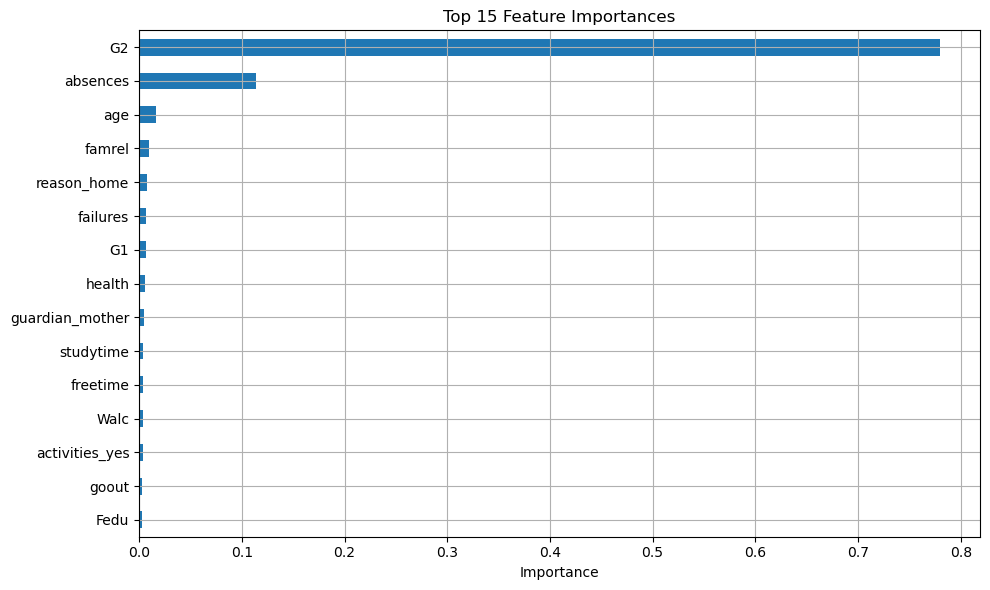

In [40]:
model = best_model.named_steps['model']
ohe = best_model.named_steps['preprocess'].transformers_[1][1]
cat_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_names)

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
import joblib

# Save the best model (pipeline)
joblib.dump(best_model, 'student_grade_predictor.pkl')

print(" Model saved as 'student_grade_predictor.pkl'")


 Model saved as 'student_grade_predictor.pkl'


In [43]:
# Load saved model
loaded_model = joblib.load('student_grade_predictor.pkl')

# Example: Predict for a single student (as DataFrame)
sample_input = X_test.iloc[[0]]  # Replace with new input as needed
predicted_grade = loaded_model.predict(sample_input)

print(" Predicted Grade:", round(predicted_grade[0], 2))


 Predicted Grade: 5.68
